# Analysis, Cleaning and Visualization of Used Car Dataset obtained by Scraping Autotrader

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing required modules
import pandas as pd
import numpy as np
from sqlalchemy import create_engine,inspect, func
from config import password

import seaborn as sns
import scipy.stats as ss
from collections import Counter
import math 
from scipy import stats
import datetime
import matplotlib
import pickle
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from spark_sklearn import GridSearchCV
from spark_sklearn.util import createLocalSparkSession
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

from statsmodels.graphics.tsaplots import plot_acf
import sqlite3

In [3]:
#Connecting to the sql database
connection_string = "postgres:"+password+"@localhost:5432/hondadb"
engine = create_engine(f'postgresql://{connection_string}')

In [4]:
# Reading the data from sql database
sql_DF = pd.read_sql("SELECT * FROM cardb",
                     con=engine)

In [5]:
#Selecting the useful columns only and removing unuseful columns
csql_DF=sql_DF[['Car Type', 'Model', 'Price', 'Milage', 'Year']]

In [6]:
csql_DF.head()

,Car Type,Model,Price,Milage,Year
0,Ford,F-150,33888,64965,2018
1,Mercedes-Benz,GLS,54887,57449,2017
2,Dodge,Journey,18888,28567,2016
3,Ford,Edge,30995,63500,2017
4,Nissan,Versa,18988,87760,2019


In [9]:
#Checking for duplicates
csql_DF[csql_DF.duplicated(subset=None, keep='first')==True]

,Car Type,Model,Price,Milage,Year
10353,Porsche,911,129900,152000,2018
13210,Lexus,RX,39999,101,2017


In [13]:
#Droping duplicate
df=csql_DF.drop_duplicates(subset=None, keep='first')

In [14]:
#Checking the dataset
df.describe()

,Car Type,Model,Price,Milage,Year
count,40991,40991,40991,40991,40991
unique,70,1014,14952,27261,77
top,Ford,F-150,14995,90,2020
freq,4919,1729,199,97,9748


In [16]:
#getting the data types in columns
print(df.dtypes)

Car Type    object
Model       object
Price       object
Milage      object
Year        object
dtype: object


In [17]:
#converting the Milage, Year and Price values to numeric
df['Milage'] = pd.to_numeric(df['Milage'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

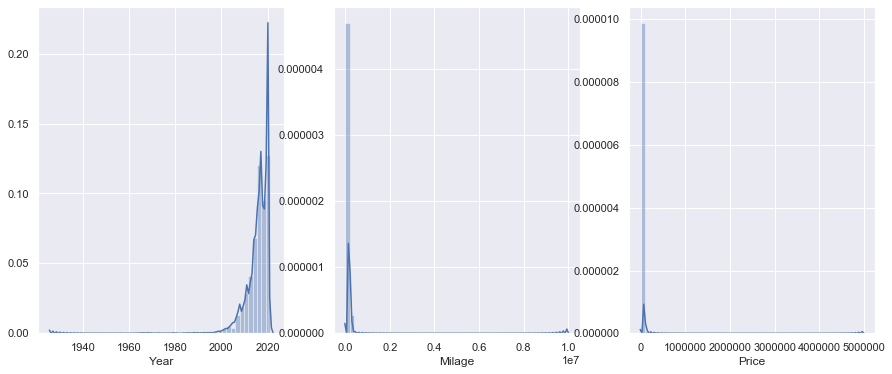

In [18]:
#Plotting out distributions for the numeric variables to see whether they are normally distributed
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2,ax3))=plt.subplots(ncols=3,nrows=1,figsize=(15,6)) 
sns.distplot(df['Year'],ax=ax1);
sns.distplot(df['Milage'],ax=ax2);            
sns.distplot(df['Price'],ax=ax3);


In [19]:
#removing some obvious outliers in model year, milage and price
df = df[(df.Year >= 1989)
      & (df.Milage <= 500000)
      & (df.Price <= 200000)]

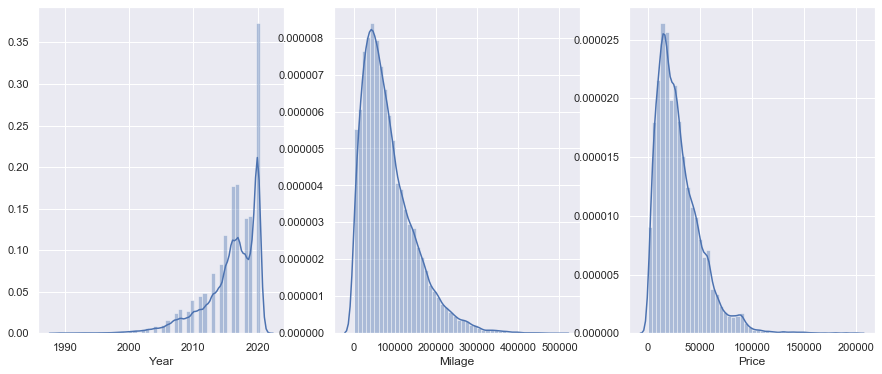

In [21]:
#Plotting out distributions for the numeric variables to see whether they are normally distributed again after removing obvious outliers
warnings.filterwarnings("ignore")
sns.set()
fig, ((ax1,ax2,ax3))=plt.subplots(ncols=3,nrows=1,figsize=(15,6)) 
sns.distplot(df['Year'],ax=ax1);
sns.distplot(df['Milage'],ax=ax2);            
sns.distplot(df['Price'],ax=ax3);
plt.savefig('1.png')

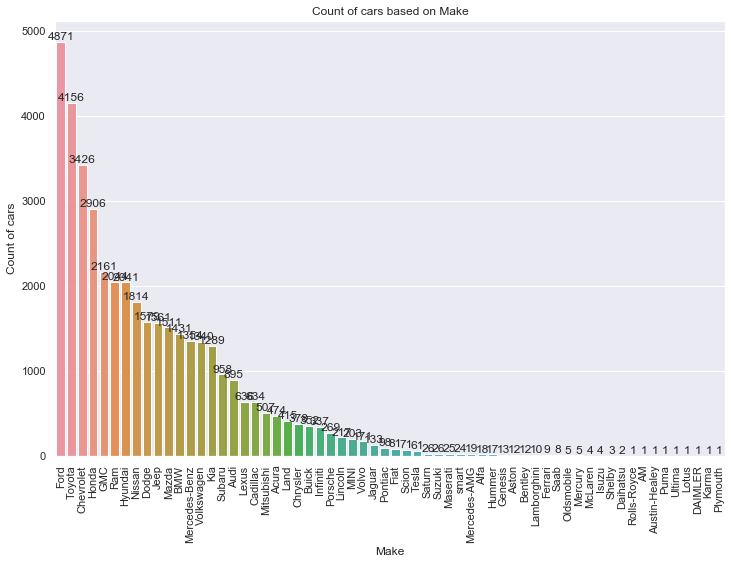

In [22]:
#Plotting the number of each cars make
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Car Type', data = df, order = df['Car Type'].value_counts().index)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on Make")
plt.xlabel("Make")
plt.ylabel("Count of cars")
plt.savefig('2.png')

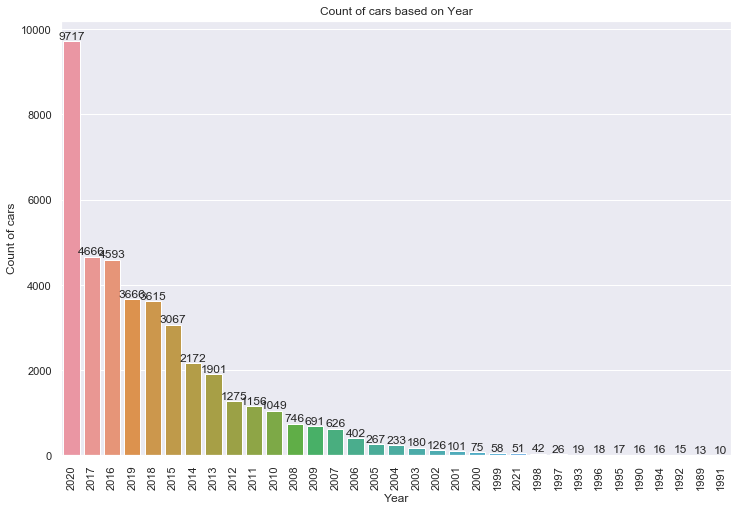

In [23]:
#Plotting the number of model years
plt.figure(figsize = (12, 8))
plot = sns.countplot(x = 'Year', data = df, order = df['Year'].value_counts().index)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Count of cars based on Year")
plt.xlabel("Year")
plt.ylabel("Count of cars")
plt.savefig('3.png')

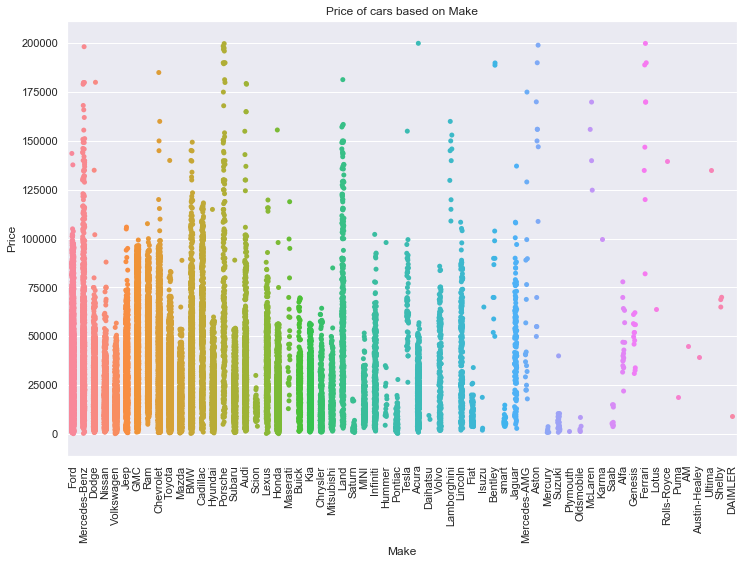

In [25]:
#checking the prices of each make
plt.figure(figsize = (12, 8))

ax=sns.stripplot(x='Car Type',y='Price', data=df,jitter=True)

plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(), 
                        (p.get_x() + p.get_width() / 2.0, 
                         p.get_height()), 
                        ha = 'center', 
                        va = 'center', 
                        xytext = (0, 5),
                        textcoords = 'offset points')

plt.title("Price of cars based on Make")
plt.xlabel("Make")
plt.ylabel("Price")
plt.savefig('4.png')

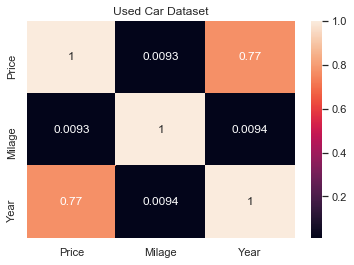

In [18]:
#checking the correlations between numerical values in the dataset
numeric_corr = df[['Price','Milage','Year']].corr(method='spearman'); # non-parametric
sns.heatmap(numeric_corr,annot=True);
plt.title('Used Car Dataset');

#### Analysis of the Price feature

In [19]:
# Converting all objects and strings to numberic values
df['Milage'] = pd.to_numeric(df['Milage'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

In [20]:
df['Price'].describe()

count     40625.000000
mean      29955.204086
std       21591.735858
min         200.000000
25%       14499.000000
50%       24995.000000
75%       40495.000000
max      199950.000000
Name: Price, dtype: float64

In [21]:
df['Milage'].describe()

count     40625.000000
mean      84053.145157
std       63849.692864
min           3.000000
25%       37354.000000
50%       69000.000000
75%      116062.000000
max      500000.000000
Name: Milage, dtype: float64

In [22]:
df['Year'].describe()

count    40625.000000
mean      2015.842437
std          4.344107
min       1989.000000
25%       2014.000000
50%       2017.000000
75%       2019.000000
max       2021.000000
Name: Year, dtype: float64

Skewness: 1.663365
Kurtosis: 5.057019


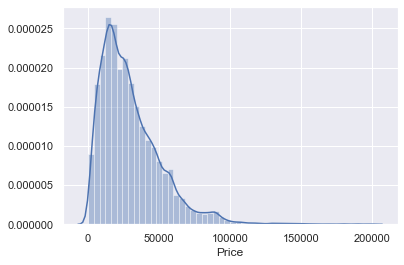

In [23]:
sns.distplot(df['Price'])
#skewness and kurtosis
print("Skewness: %f" % df['Price'].skew())
print("Kurtosis: %f" % df['Price'].kurt())

The data are skewed (skewness = 1.66) and have a kurtosis of 5.05 which means there are still outliers in data.

#### Investigation of Corelations (Numerical Features)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


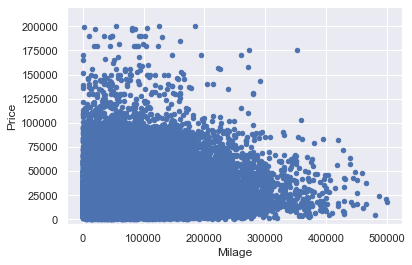

In [24]:
# distribution of  Milage / Price
data = pd.concat([df['Price'], df['Milage']], axis=1)
data.plot.scatter(x='Milage', y='Price', ylim=(-5000,220000));

It cen be observed that lesser is the milage, the higher tends to be the price. Price and Milage are in a reverse correlation. Some milage bins show some outliers.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


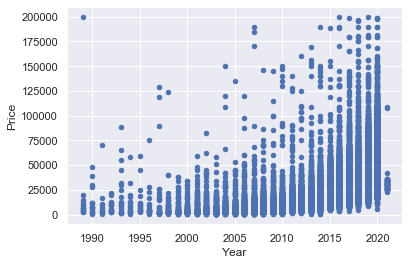

In [25]:
# distribution of  Year / Price
data = pd.concat([df['Price'], df['Year']], axis=1)
data.plot.scatter(x='Year', y='Price');#, ylim=(-5000,220000));

From the plot above, It cen be observed that the newer the car, the higher the price will be. Price and model year are in a direct correlation. One outlier is observed where the car is very old however the price is high which might be because of the cars being a classic car. We will remove that car.

In [26]:
#identifying the outlier with high price and low model year 
outlier = df[(df['Price']>100000) & (df['Year']<1990)]
outlier

,Car Type,Model,Price,Milage,Year
26214,Ferrari,328,199900,184901,1989


In [27]:
#removing the outlier
df=df[df['Price']!=199900]

<Figure size 2160x2160 with 0 Axes>

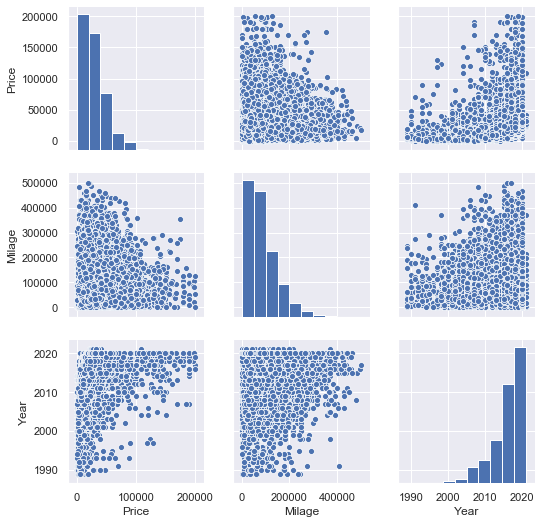

In [28]:
# PairPlots to have more insight into the correlations between numerical features
plt.figure(figsize = (30,30))
sns.pairplot(df)
plt.show()

#### Investigation of Corelations (categorical Features)

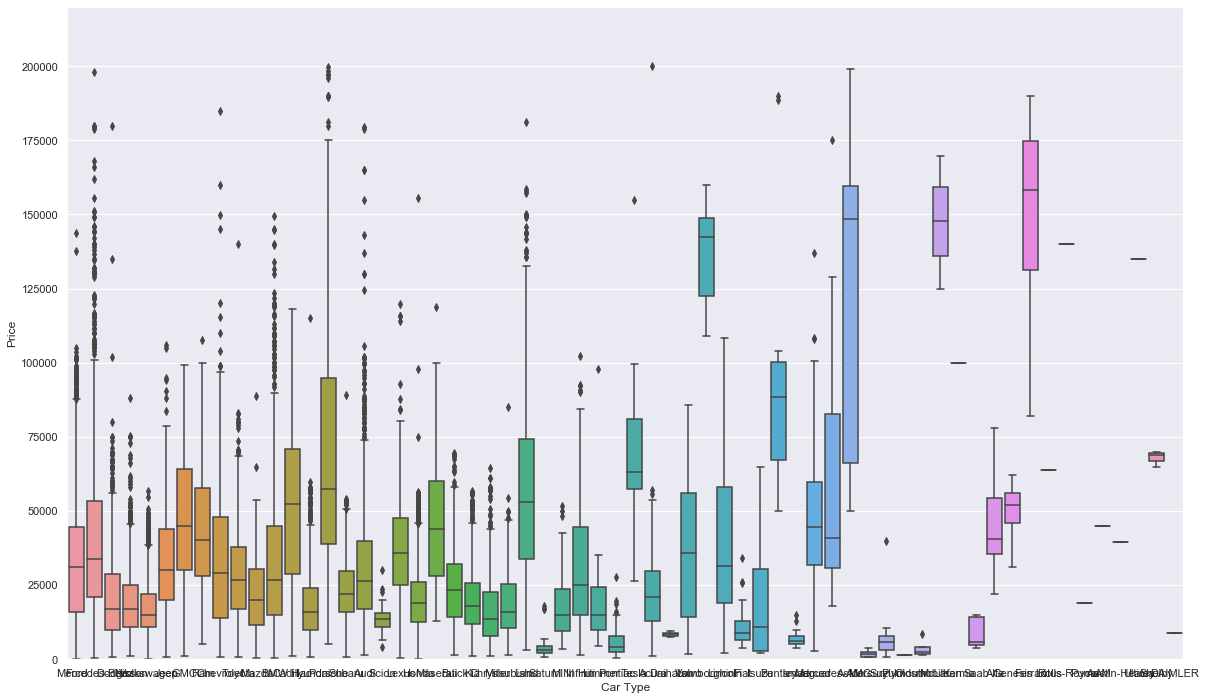

In [29]:
# Box plot Make Model/Price
data = pd.concat([df['Price'], df['Car Type']], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x="Car Type", y="Price", data=data)
fig.axis(ymin=0, ymax=220000);

We can clearly see that some makes are more expensive that others. There are still some outliers in data for different makes.

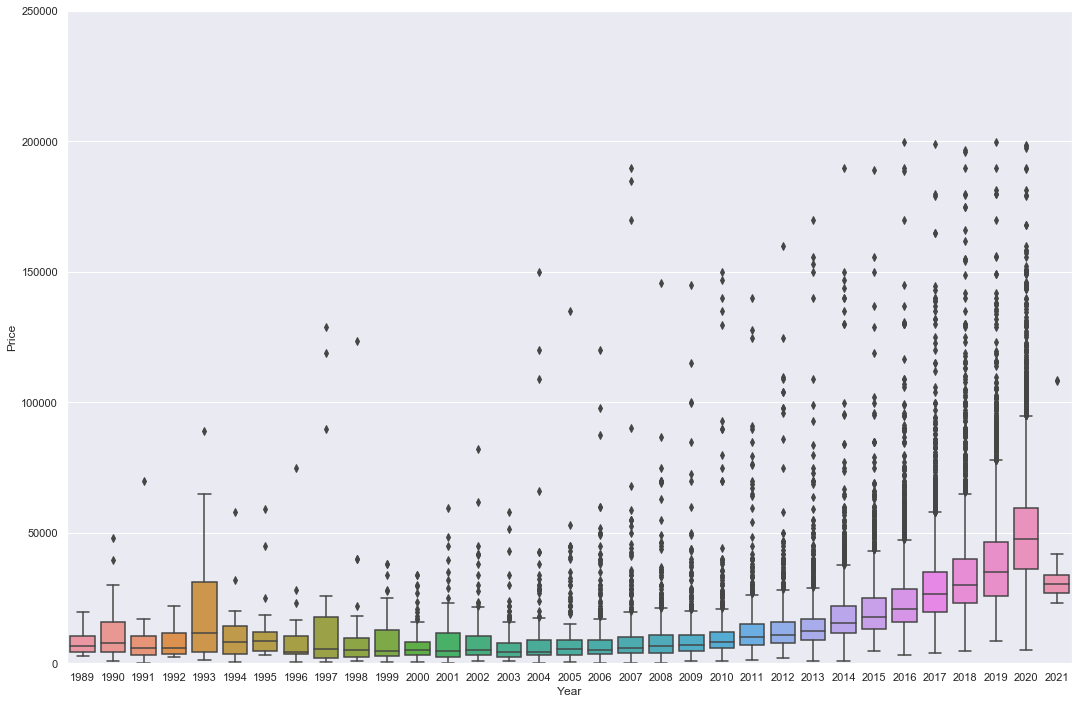

In [30]:
# Box plot Year/Price
data = pd.concat([df['Price'], df['Year']], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x='Year', y="Price", data=data)
fig.axis(ymin=0, ymax=250000);

Obviously there is a correlation bertween the year (model year) and the price. The newer the car, the higher the price. Again many outliers are observed in data.

#### Investigation of the Importance of Features Related to Target

In [31]:
# Finding most important features relative to Price
corr = df.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.570298
Milage    0.007439
Name: Price, dtype: float64


Between the year (model year) and price there is a direct correlation and the newer the car the higher will be the price. 

#### Preprocessing

In [32]:
# Checking for missing values -> no missing values
df.isnull().sum()

Car Type    0
Model       0
Price       0
Milage      0
Year        0
dtype: int64

In [33]:
# Checking for values of numerical features
# we need to fix these problems
df.describe()

,Price,Milage,Year
count,40624.000000,40624.000000,40624.000000
mean,29951.020727,84050.662687,2015.843098
std,21575.531477,63848.518161,4.342119
min,200.000000,3.000000,1989.000000
25%,14499.000000,37354.000000,2014.000000
50%,24995.000000,69000.000000,2017.000000
75%,40489.750000,116059.000000,2019.000000
max,199950.000000,500000.000000,2021.000000


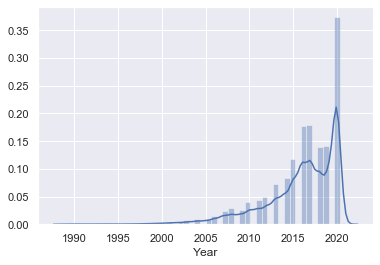

In [34]:
# Record distribution over the year
sns.distplot((df["Year"]))

In [35]:
# Checking values of categorical features
cat_val = ["Model", "Car Type"]
for col in cat_val:
    print ([col]," : ", csql_DF[col].unique())

['Model']  :  ['F-150' 'GLS' 'Journey' ... 'CBR600' 'Chrysler' 'G25X']
['Car Type']  :  ['Ford' 'Mercedes-Benz' 'Dodge' 'Nissan' 'Volkswagen' 'Jeep' 'GMC' 'Ram'
 'Chevrolet' 'Toyota' 'Mazda' 'BMW' 'Cadillac' 'Hyundai' 'Porsche'
 'Subaru' 'Audi' 'Scion' 'Lexus' 'Honda' 'Maserati' 'Buick' 'Kia'
 'Chrysler' 'Mitsubishi' 'Land' 'Saturn' 'MINI' 'Pontiac' 'Infiniti'
 'Hummer' 'Tesla' 'Acura' 'Oldsmobile' 'Mercury' 'Daihatsu' 'Volvo'
 'Lamborghini' 'Lincoln' 'Fiat' 'Isuzu' 'Ferrari' 'Bentley' 'smart'
 'Jaguar' 'Alfa' 'Mercedes-AMG' 'Aston' 'Datsun' 'Suzuki' 'MG' 'Plymouth'
 'De' 'McLaren' 'Karma' 'Saab' 'Rolls-Royce' 'Triumph' 'Genesis' 'Lotus'
 'Puma' 'AM' 'Austin' 'Shelby' 'Austin-Healey' 'Ultima' 'International'
 'Nash' 'Avanti-Studebaker' 'DAIMLER']


#### Outlier management


##### Bivariate Analysis

##### Removing Outliers by Model



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


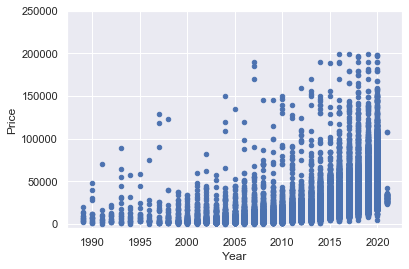

In [36]:
# Bivariate analysis Price / Year
data = pd.concat([df['Price'], df['Year']], axis=1)
data.plot.scatter(x='Year', y='Price', ylim=(-5000,250000));

We will only use the data between 20 and 80 percentile of the price guassian curve.

In [37]:
from numpy import percentile
from functools import partial

category='Model'

models = df[category].unique()


p20 = df.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 20))
p80 = df.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 80))

In [38]:
# Now this strategy is applied to the models
# depending on the hardware
models = df[category].unique()

cdf = pd.DataFrame()

for i,m in enumerate(models):
    cdf=cdf.append(df[( (df[category] == m ) & ( (df["Price"] > p20.Model[m]) & (df["Price"] <= p80.Model[m])) ) ],ignore_index=True)

In [39]:
cdf

,Car Type,Model,Price,Milage,Year
0,Ford,F-150,33888,64965,2018
1,Ford,F-150,46980,100000,2018
2,Ford,F-150,29995,88300,2016
3,Ford,F-150,43701,74900,2020
4,Ford,F-150,49950,73987,2019
5,Ford,F-150,34999,58443,2018
6,Ford,F-150,36999,74526,2016
7,Ford,F-150,26379,35400,2016
8,Ford,F-150,35994,79950,2019
9,Ford,F-150,31995,133000,2016


#### Create database connection

In [40]:
from config import password
connection_string = "postgres:"+password+"@localhost:5432/hondadb"
engine = create_engine(f'postgresql://{connection_string}')

In [41]:
cdf.to_sql(name='cleanedcardb', con=engine, if_exists='replace', index=True)

In [70]:
csql_DF_cleaned = pd.read_sql("SELECT * FROM cleanedcardb",
                     con=engine)

In [71]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23707.000000,23707.000000,23707.000000,23707.00000
mean,11853.000000,29524.735479,83906.444088,2016.57076
std,6843.765752,17250.757844,63810.344233,3.14560
min,0.000000,1495.000000,3.000000,1989.00000
25%,5926.500000,16779.500000,37306.500000,2015.00000
50%,11853.000000,25986.000000,69000.000000,2017.00000
75%,17779.500000,38985.500000,116000.000000,2019.00000
max,23706.000000,169800.000000,500000.000000,2021.00000


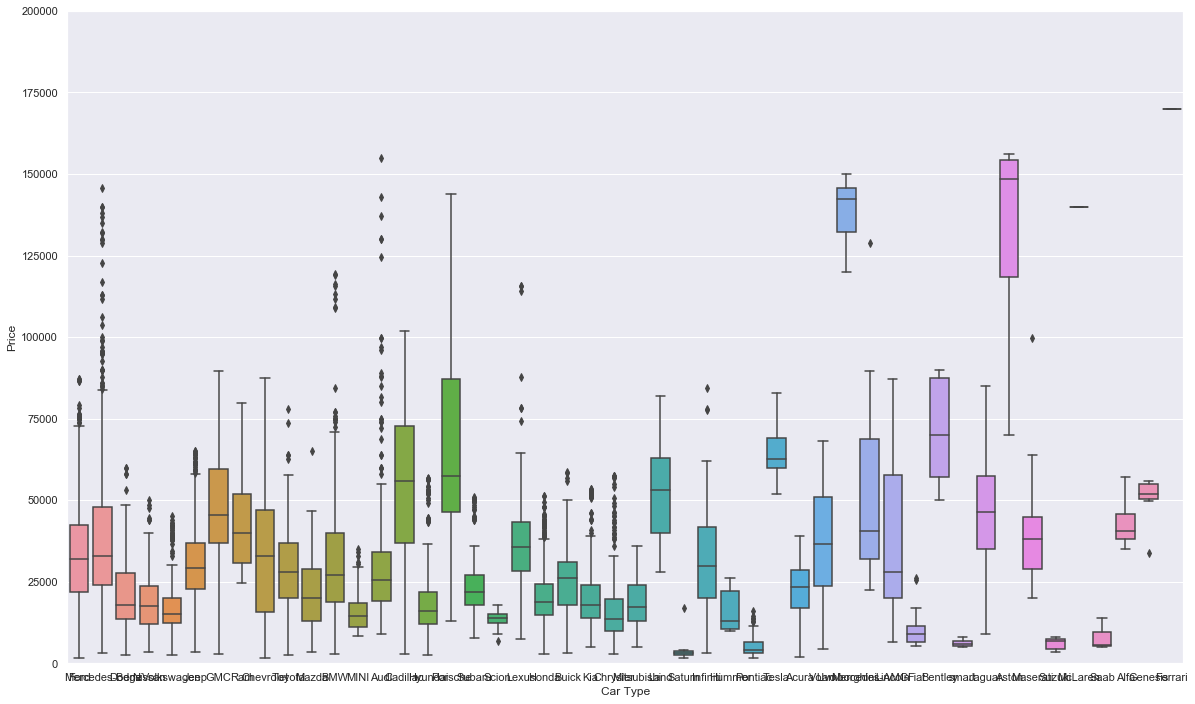

In [72]:
# Box Plot showing car manufacturer / Price range after cleaning

data = pd.concat([csql_DF_cleaned['Price'], csql_DF_cleaned['Car Type']], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x='Car Type', y="Price", data=data)
fig.axis(ymin=0, ymax=200000);

In [73]:
print("Too old: %d" % csql_DF_cleaned.loc[csql_DF_cleaned.Year <= 1995].count()['index'])
print("Too new: %d" % csql_DF_cleaned.loc[csql_DF_cleaned.Year >= 2021].count()['index'])
print("Too few km: " , csql_DF_cleaned.loc[csql_DF_cleaned.Milage <= 10].count()['index'])
print("Too many km: " , csql_DF_cleaned.loc[csql_DF_cleaned.Milage >= 400000].count()['index'])


Too old: 21
Too new: 28
Too few km:  23
Too many km:  26


In [74]:
# Replace the NaN values for categoric attributes
csql_DF_cleaned['Model'].fillna(value='blank', inplace=True)

# Drop duplicates
csql_DF_cleaned = csql_DF_cleaned.drop_duplicates(["Year", "Milage", "Price", "Model", "Car Type"])
csql_DF_cleaned.drop_duplicates(keep=False, inplace=True)
# Remove outliers
csql_DF_cleaned = csql_DF_cleaned[
        (csql_DF_cleaned.Year >= 1995) 
      & (csql_DF_cleaned.Year <= 2021)  
      & (csql_DF_cleaned.Milage >= 10) 
      & (csql_DF_cleaned.Milage <= 500000)
      & (csql_DF_cleaned.Price <= 400000)]

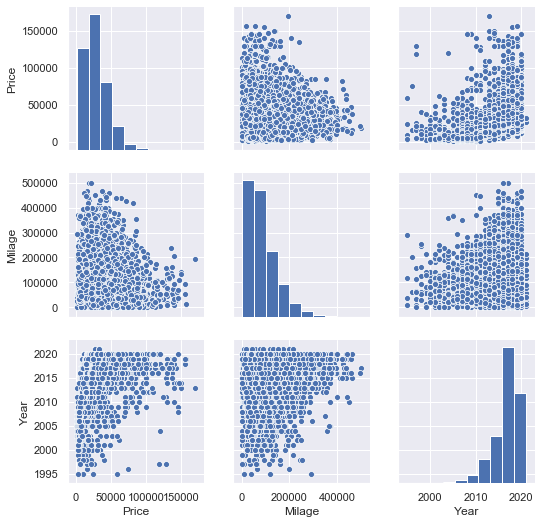

In [75]:
# pairplot for numerical features
num_features = ["Price", "Milage", "Year"]
sns.pairplot(csql_DF_cleaned[num_features], size = 2.5)
plt.show();

#### P-value Analysis:

The P-value indicates the correlation between  two variables is statistically significant. In general, a significance level of 0.05 is selected, which translate to 95% confidence that the correlation between the variables is significant.


p-value < 0.001: indicates a strong evidence that the correlation is significant.

p-value < 0.05: indicates a moderate evidence that the correlation is significant.

p-value < 0.1: indicates a weak evidence that the correlation is significant.

p-value > 0.1: means there is no evidence that the correlation is significant.

In [76]:
# Correlation between Price and Year
pearson_coef, p_value = stats.pearsonr(csql_DF_cleaned['Year'], csql_DF_cleaned['Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.5164306425791607  with a P-value of P = 0.0


In [77]:
# Correlation between Milage and Year
pearson_coef, p_value = stats.pearsonr(csql_DF_cleaned['Milage'], csql_DF_cleaned['Price'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.005765674851078775  with a P-value of P = 0.3750013283578679


#### Grouping

The data are grouped by the variable "Car Type" i.e. the make.

In [78]:
csql_DF_cleaned['Car Type'].unique()

array(['Ford', 'Mercedes-Benz', 'Dodge', 'Nissan', 'Volkswagen', 'Jeep',
       'GMC', 'Ram', 'Chevrolet', 'Toyota', 'Mazda', 'BMW', 'MINI',
       'Audi', 'Cadillac', 'Hyundai', 'Porsche', 'Subaru', 'Scion',
       'Lexus', 'Honda', 'Buick', 'Kia', 'Chrysler', 'Mitsubishi', 'Land',
       'Saturn', 'Infiniti', 'Hummer', 'Pontiac', 'Tesla', 'Acura',
       'Volvo', 'Lamborghini', 'Mercedes-AMG', 'Lincoln', 'Fiat',
       'Bentley', 'smart', 'Jaguar', 'Aston', 'Maserati', 'Suzuki',
       'McLaren', 'Saab', 'Alfa', 'Genesis', 'Ferrari'], dtype=object)

If order to understand, on average, which Car Type (make) is the most valuable, we can group the data by "Car Type" and then average them.

We can select the columns 'Car Type', 'Model' and 'Price', then assign it to the variable "df_group_makemodel".

In [79]:
df_group_makemodel = df[['Car Type','Model','Price']]

Then the average price for each of the different categories of data is calculated.

In [80]:
# grouping results
df_group_make = df_group_makemodel.groupby(['Car Type'],as_index=False).mean()
df_group_make.sort_values(by='Price', ascending=False)

,Car Type,Price
15,Ferrari,150292.500000
37,McLaren,147622.000000
49,Rolls-Royce,139888.000000
29,Lamborghini,136747.700000
58,Ultima,135000.000000
3,Aston,125541.416667
27,Karma,99900.000000
7,Bentley,95716.250000
46,Porsche,69173.695167
53,Shelby,67930.000000


As its observed, Ferrari, McLaren and  Rolls-Royce are the most expensive, whereas  Plymouth, Mercury and Oldsmobile appear to be the cheapest cars.

Grouping with multiple variables. Let's group by both 'Car Type' and 'Model'. This groups the dataframe by the unique combinations 'Car Type' and 'Model'. We can store the results in the variable 'grouped_makemodel'.

In [83]:
# grouping results
grouped_makemodel = df_group_makemodel.groupby(['Car Type','Model'],as_index=False).mean()
grouped_makemodel.sort_values(by='Price', ascending=False)

,Car Type,Model,Price
6,Acura,NSX,199950.000000
836,Porsche,Taycan,198510.000000
147,Bentley,Flying,188750.000000
295,Ferrari,599,179987.000000
596,McLaren,570S,169888.000000
296,Ferrari,California,168496.000000
734,Mercedes-Benz,S560C4,168146.000000
598,Mercedes-AMG,AMG,152000.000000
597,McLaren,MP4-12C,140200.000000
846,Rolls-Royce,Ghost,139888.000000


#### ANOVA: Analysis of Variance

The Analysis of Variance (ANOVA) is a statistical method used to test whether there is a significant difference between the means of two or more groups. ANOVA returns two parameters:

#### F-test score: 
ANOVA assumes the means of all groups are the same, calculates how much the actual means deviate from the assumption, and reports it as the F-test score. A larger score means there is a larger difference between the means.

#### P-value: 
P-value tells how statistically significant is our calculated score value.

If our price variable is strongly correlated with the variable we are analyzing, we expect ANOVA to return a large F-test score and a small p-value.

#### Car Type (Make)

As ANOVA analyzes the difference between different groups of the same variable, the groupby function will be used. Because the ANOVA algorithm averages the data automatically, we do not need to take the average before hand.

We will groupby the Car Type (Make).

In [92]:
df_group_makeprice = df_group_makemodel[['Car Type', 'Price']].groupby(['Car Type'])
df_group_makeprice.head(1)

,Car Type,Price
0,Ford,33888
1,Mercedes-Benz,54887
2,Dodge,18888
4,Nissan,18988
5,Volkswagen,33995
6,Jeep,25688
7,GMC,16998
8,Ram,42390
13,Chevrolet,14998
15,Toyota,12950


In [93]:
df_group_makemodel

,Car Type,Model,Price
0,Ford,F-150,33888
1,Mercedes-Benz,GLS,54887
2,Dodge,Journey,18888
3,Ford,Edge,30995
4,Nissan,Versa,18988
5,Volkswagen,Golf,33995
6,Jeep,Grand,25688
7,GMC,Acadia,16998
8,Ram,1500,42390
9,Jeep,Compass,40665


We can obtain the values of the group using "get_group".

In [95]:
df_group_makeprice.get_group('Honda')['Price']

98       26945
107      23900
113       7899
115      19550
148       6888
151      24745
184      12992
185      16458
220       6995
236       5499
244      16997
249      16995
256       6994
259       6500
261      33305
289       6600
343      19800
345      13995
349      12995
350       5495
351      10995
354       6995
356      17995
357      25995
363       9995
366      13000
379      26990
380      32334
381      17777
382      30898
         ...  
40562     6399
40581    45398
40585    16300
40596     2500
40646     5200
40649     5000
40661    11400
40663    11500
40666     4800
40699    18888
40726    10945
40732     4329
40733    25663
40744    18295
40745    28795
40777    15333
40795    18698
40796    22997
40797    15998
40798    21494
40803    17988
40807     8500
40808    15584
40863    48800
40891    19990
40895    10551
40896    35990
40912    38000
40947     1700
40992    56031
Name: Price, Length: 2906, dtype: int64

we can use the function 'f_oneway' in the module 'stats' to obtain the F-test score and P-value.

In [105]:
# ANOVA
f_val, p_val = stats.f_oneway(df_group_makeprice.get_group('Honda')['Price'], df_group_makeprice.get_group('Toyota')['Price'], df_group_makeprice.get_group('Nissan')['Price'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val)

ANOVA results: F= 516.8534470033683 , P = 4.723786365637106e-213


A large F test score shows a strong correlation and a P value of almost 0 indicates almost certain statistical significance. Are the prices for these three Japanese Car makes this highly correlated?

##### Honda and Toyota

In [106]:
f_val, p_val = stats.f_oneway(df_group_makeprice.get_group('Honda')['Price'], df_group_makeprice.get_group('Toyota')['Price'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val )

ANOVA results: F= 646.5261506326442 , P = 1.5294212106814525e-136


##### Honda and Nissan

In [107]:
f_val, p_val = stats.f_oneway(df_group_makeprice.get_group('Honda')['Price'], df_group_makeprice.get_group('Nissan')['Price'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val )

ANOVA results: F= 18.0828949455872 , P = 2.1558390972748604e-05


##### Toyota and Nissan

In [108]:
f_val, p_val = stats.f_oneway(df_group_makeprice.get_group('Toyota')['Price'], df_group_makeprice.get_group('Nissan')['Price'])  
 
print( "ANOVA results: F=", f_val, ", P =", p_val )

ANOVA results: F= 631.9502336436865 , P = 1.2206821716521076e-132


It seems the Japanese Car makes and their prices are highly correlated.

In [110]:
#storing the unnormalized dataset as a sqlite file
conn = sqlite3.connect('unnormcleanedcar.sqlite')
csql_DF_cleaned.to_sql('unnormalizedcarsdb', conn, if_exists='replace', index=False)

#### Normalizing the distribution of Prices

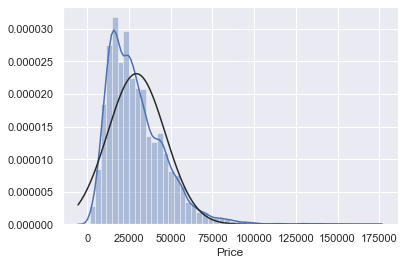

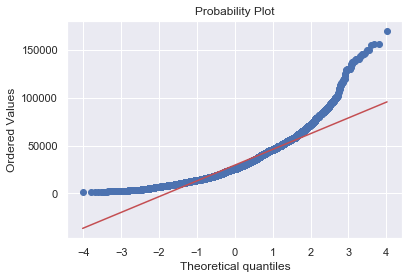

In [111]:
# Distribution of prices
from scipy.stats import norm
from scipy import stats

# Using Histogram and normal probability plot
sns.distplot(csql_DF_cleaned['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(csql_DF_cleaned['Price'], plot=plt)

In [112]:
# Finding most important features relative to Price
corr = csql_DF_cleaned.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.516431
Milage   -0.005766
index    -0.049187
Name: Price, dtype: float64


In [113]:
#applying log transformation
csql_DF_cleaned['Price'] = np.log(csql_DF_cleaned['Price'])

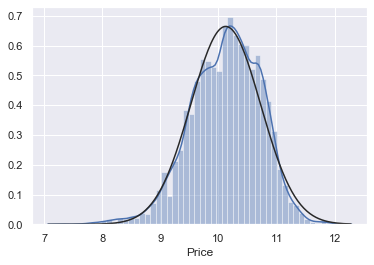

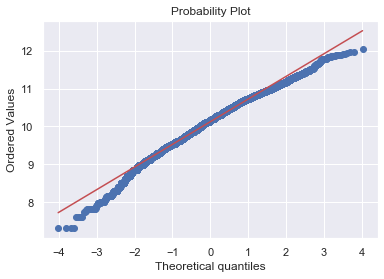

In [114]:
#transformed histogram and normal probability plot
sns.distplot(csql_DF_cleaned['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(csql_DF_cleaned['Price'], plot=plt)

In [115]:
# Finding most important features relative to Price
corr = csql_DF_cleaned.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

Price     1.000000
Year      0.644284
Milage   -0.004134
index    -0.117610
Name: Price, dtype: float64


In [116]:
csql_DF_cleaned.describe()

,index,Price,Milage,Year
count,23677.000000,23677.000000,23677.000000,23677.000000
mean,11846.972801,10.125652,83959.113359,2016.588588
std,6841.809995,0.600556,63801.946178,3.075055
min,0.000000,7.309881,10.000000,1995.000000
25%,5922.000000,9.728300,37344.000000,2015.000000
50%,11844.000000,10.165275,69000.000000,2017.000000
75%,17772.000000,10.570984,116000.000000,2019.000000
max,23706.000000,12.042377,500000.000000,2021.000000


In [117]:
csql_DF_cleaned.to_sql(name='cleanedcardb2', con=engine, if_exists='replace', index=True)

In [118]:
conn = sqlite3.connect('cleanedcar.sqlite')
csql_DF_cleaned.to_sql('cleanedcarsdb', conn, if_exists='replace', index=False)